In [4]:
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser import waveforms
from pulser_simulation import QutipEmulator
import qutip
import matplotlib.pyplot as plt
import numpy as np

In [5]:
V = [0,1,2]
E = [(0,1), (1,2)]

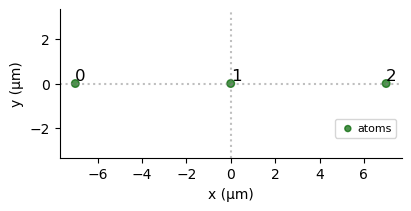

In [6]:
coords = [[-7, 0], [0,0], [7,0]]
reg = Register.from_coordinates(coords)
reg.draw()

In [7]:
def generate_pulses(
    beta, # duration of Mixing Hamiltonian H_M
    gamma, # duration of Problem Hamiltonian H_P
    omega, # amplitude of H_M
    delta, # detuning in H_P
):
    # amplitude on, detuning off
    mixing_pulse = Pulse.ConstantPulse(
        duration = beta,
        amplitude = omega,
        detuning = 0,
        phase = 0
    )

    # amplitude off, detuning on
    problem_pulse = Pulse.ConstantPulse(
        duration = gamma,
        amplitude = 0,
        detuning = delta,
        phase = 0,
    )

    return mixing_pulse, problem_pulse
    

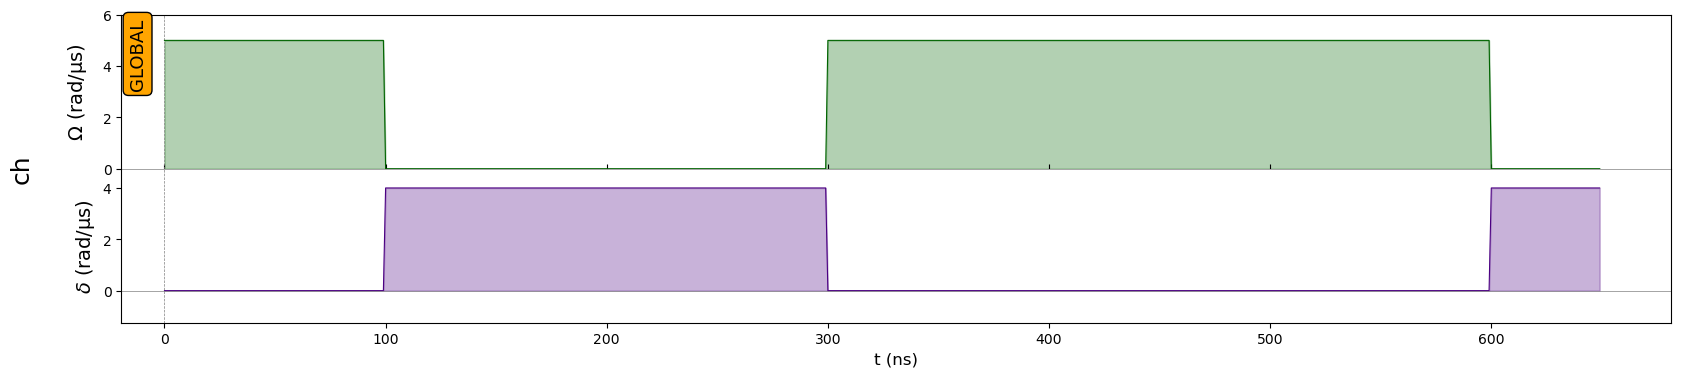

In [ ]:
# This is a random 2 layer QAOA pulse

seq = Sequence(reg, MockDevice)
seq.declare_channel('ch', 'rydberg_global')

pulse_m, pulse_p = generate_pulses(100, 200, 5, 4)
seq.add(pulse_m, 'ch')
seq.add(pulse_p, 'ch')
pulse_m, pulse_p = generate_pulses(300, 50, 5, 4)
seq.add(pulse_m, 'ch')
seq.add(pulse_p, 'ch')

seq.draw()

In [10]:
# Let's use skopt bayesian minimizer for QAOA

from skopt import gp_minimize, gbrt_minimize, forest_minimize

In [20]:
def MIS_cost(samples, graph):
    # weighted average of the cost of each bitstring sampled
    
    cost = 0
    V, E = graph
    n_samples = sum(samples.values())

    for bitstring, frequency in samples.items():
        b_cost = 0
        # linear part of the cost
        for b in bitstring:
            if b =='1':
                b_cost -= 1
        # quadratic part of the cost
        for edge in E:
            i,j = edge
            if (bitstring[i] == '1') and (bitstring[j]=='1'):
                b_cost += 2
        cost += frequency*b_cost
    
    return cost/n_samples



def QAOA_minimizer(register, omega, delta, graph, N_layers, minimizer):
    # define a score function
    def score(params):
        # params = [beta_1, gamma_1, beta_2, gamma_2, ....]
        # len(params) = 2*N_layers
        seq = Sequence(register, MockDevice)
        seq.declare_channel('ch', 'rydberg_global')
        for l in range(N_layers):
            pulse_m, pulse_p = generate_pulses(
                beta = params[2*l],
                gamma = params[2*l + 1],
                omega = omega,
                delta = delta,
            )
            seq.add(pulse_m, 'ch')
            seq.add(pulse_p, 'ch')
        sim = QutipEmulator.from_sequence(seq)
        results = sim.run()
        samples = results.sample_final_state(1000)
        # samples = {'111': 21, '101': 5, ...}
        return MIS_cost(samples, graph)

    # call the baysian minimizer
    optimization_results = minimizer(
        func = score,
        dimensions = [(50, 500)]*2*N_layers,
        n_calls = 50,
        n_random_starts = 5,
    )

    return optimization_results


In [29]:
minimization_results = QAOA_minimizer(
    register = reg,
    omega = 5,
    delta = 4,
    graph = (V,E),
    N_layers = 4,
    minimizer = gbrt_minimize,
)

In [30]:
minimization_results.x

[476, 478, 216, 453, 75, 335, 133, 440]

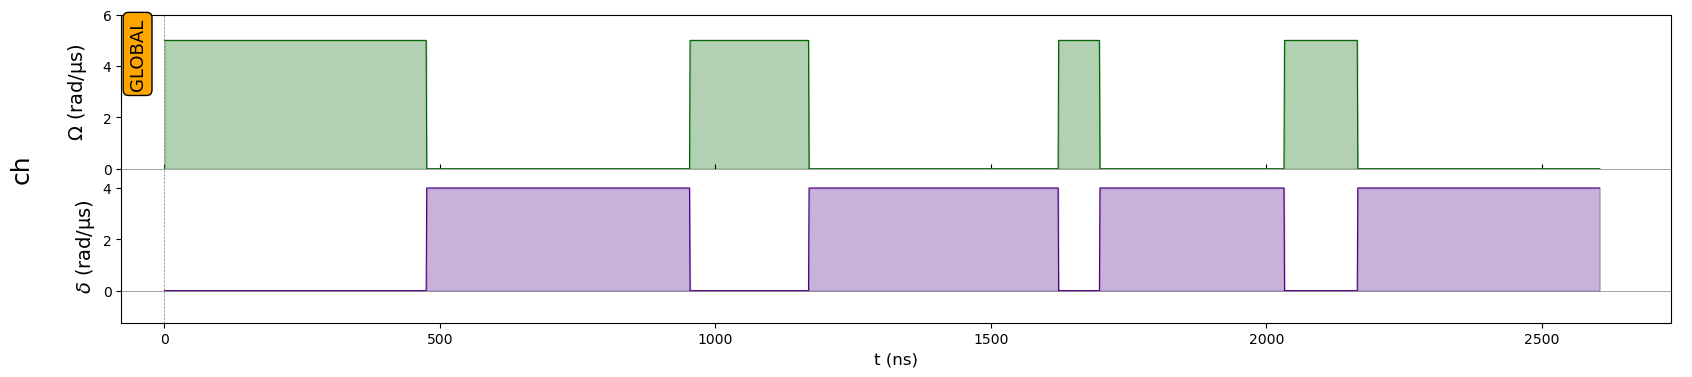

Counter({'010': 388, '101': 327, '001': 140, '100': 120, '000': 25})

In [32]:
params = minimization_results.x
seq = Sequence(reg, MockDevice)
seq.declare_channel('ch', 'rydberg_global')
for l in range(4):
    pulse_m, pulse_p = generate_pulses(
        beta = params[2*l],
        gamma = params[2*l + 1],
        omega = 5,
        delta = 4,
    )
    seq.add(pulse_m, 'ch')
    seq.add(pulse_p, 'ch')
seq.draw()
sim = QutipEmulator.from_sequence(seq)
results = sim.run()
samples = results.sample_final_state(1000)
samples

<Axes: >

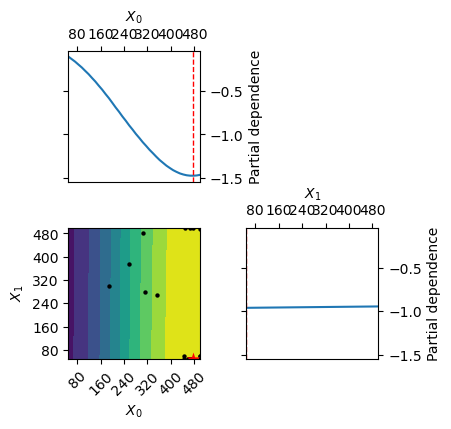

In [19]:
from skopt.plots import plot_objective

plot_objective(results)

In [ ]:
# Exercise: solve the MIS on the following graph with QAOA

V = [0,1,2,3,4,5]
E = [(0,1), (1,2), (2,3), (3,4), (3,5)]

In [ ]:
# Exercise 2: replace the MIS cost function with MAXCUT
# (or any other optimization problem that you want)